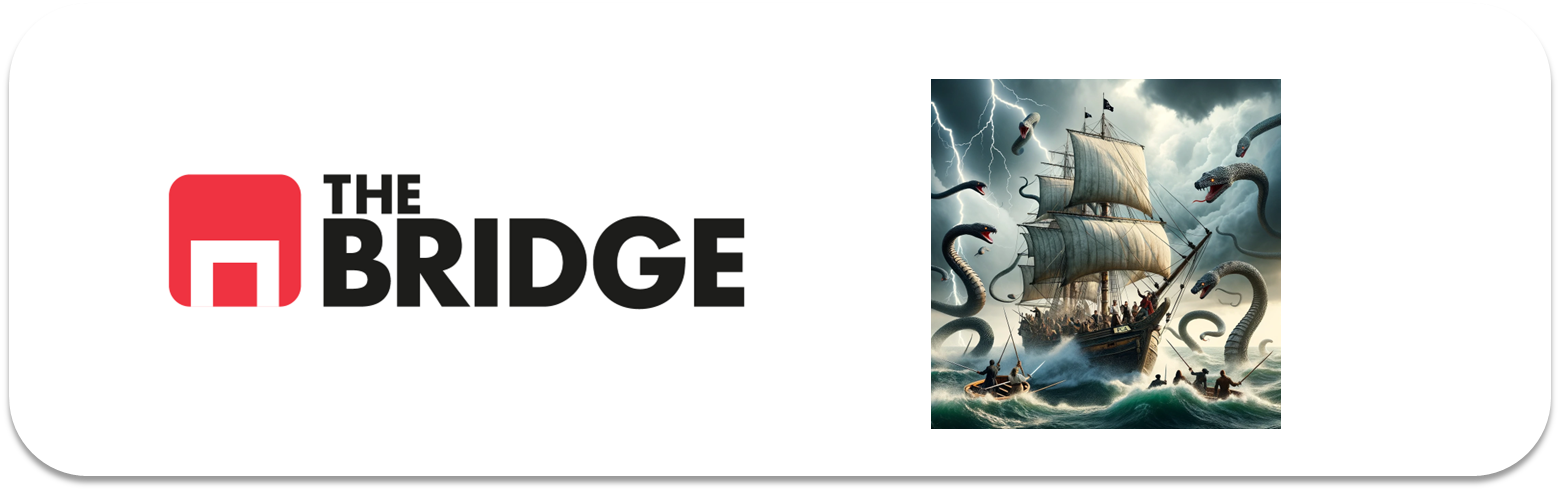

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

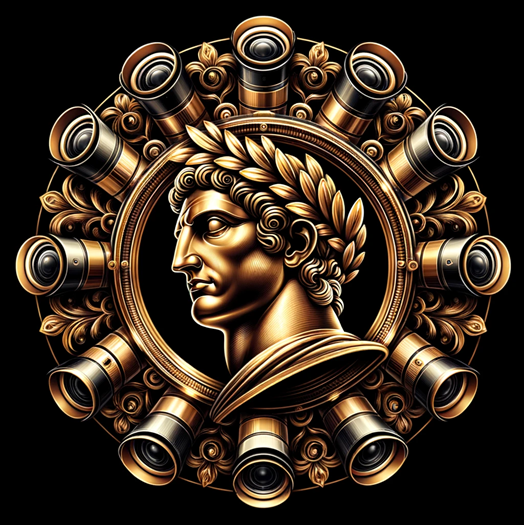

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import make_pipeline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [4]:
# 1-  Crear un DF de las caras

caras = fetch_olivetti_faces()
data = pd.DataFrame(caras.data)
target = pd.Series(caras.target, name='target')
# añadir el target
data['target'] = target

In [8]:
# Se puede observar que cada fila corresponde a una imagen aplanada. El target identifica la persona a la que corresponde la foto
data.head(20)

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0
5,0.549587,0.545455,0.541322,0.537190,0.537190,0.533058,0.528926,0.533058,0.590909,0.611570,...,0.619835,0.623967,0.615702,0.661157,0.661157,0.690083,0.714876,0.706612,0.702479,0
6,0.330579,0.305785,0.330579,0.351240,0.425620,0.500000,0.603306,0.632231,0.644628,0.644628,...,0.541322,0.541322,0.524793,0.537190,0.487603,0.190083,0.144628,0.152893,0.152893,0
7,0.128099,0.185950,0.247934,0.314050,0.388430,0.462810,0.520661,0.557851,0.590909,0.623967,...,0.157025,0.165289,0.148760,0.157025,0.157025,0.152893,0.152893,0.173554,0.173554,0
8,0.243802,0.297521,0.367769,0.454545,0.495868,0.537190,0.578512,0.603306,0.611570,0.632231,...,0.669421,0.537190,0.235537,0.169421,0.177686,0.190083,0.190083,0.181818,0.190083,0
9,0.380165,0.442149,0.483471,0.545455,0.582645,0.628099,0.648760,0.677686,0.690083,0.710744,...,0.157025,0.165289,0.148760,0.165289,0.173554,0.173554,0.173554,0.173554,0.173554,0


In [5]:
# 2- Spit de datos con 80 instancias en el test y estratificado

X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=80, stratify=data['target'], random_state=42)

In [6]:
# 3- Mini EDA

print(f"Dimensiones del dataset completo: {data.shape}")
print(f"Distribución del target en el dataset completo:\n{data['target'].value_counts(normalize=True)}")

Dimensiones del dataset completo: (400, 4097)
Distribución del target en el dataset completo:
target
0     0.025
1     0.025
22    0.025
23    0.025
24    0.025
25    0.025
26    0.025
27    0.025
28    0.025
29    0.025
30    0.025
31    0.025
32    0.025
33    0.025
34    0.025
35    0.025
36    0.025
37    0.025
38    0.025
21    0.025
20    0.025
19    0.025
9     0.025
2     0.025
3     0.025
4     0.025
5     0.025
6     0.025
7     0.025
8     0.025
10    0.025
18    0.025
11    0.025
12    0.025
13    0.025
14    0.025
15    0.025
16    0.025
17    0.025
39    0.025
Name: proportion, dtype: float64


In [ ]:
'''
 - Cada fila corresponde a una imagen de un total de 400 imágenes, 40 personas > 10 imágenes por persona
 - El DF muestra estas imágenes de forma aplanada, se puede observar que son de 64X64 px y que cada columna representa un pixel
 - Por tanto, no tiene sentido realizar ningún procesamiento previo ya que por el momento, cada columna es importante. Más adelante reduciremos y comprimiremos el contenido
'''

In [9]:
# 4- Entrenamiento de modelo y métricas

# Instanciar RandomForest
clf = RandomForestClassifier(random_state=42)

# Calcular el balanced_accuracy con 5 folds
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='balanced_accuracy')

# Entrenar el modelo 
clf.fit(X_train, y_train)

# Predeci+ct
y_pred = clf.predict(X_test)

# balanced_accuracy en el conjunto de test
test_score = balanced_accuracy_score(y_test, y_pred)

cv_scores_mean = cv_scores.mean()

print(f"Balanced Accuracy Media CV: {cv_scores_mean}")
print(f"Balanced Accuracy en Test: {test_score}")

Balanced Accuracy Media CV: 0.9349999999999999
Balanced Accuracy en Test: 0.95


### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [11]:
# 1- Instanciar PCA en train

pca = PCA()
pca.fit(X_train)

PCA()

In [12]:
# 2- Rango de valores para la compresión
# NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original

# Calcular el rango de valores para el número de componentes de PCA basado en el porcentaje de compresión
compresiones = [0.002, 0.005, 0.01, 0.015, 0.025]  # Compresiones del 0.2% al 2.5%
num_componentes = [int(c * 4096) for c in compresiones] # c representa a cada pixel

print("Número de componentes para los porcentajes de compresión seleccionados:", num_componentes)


Número de componentes para los porcentajes de compresión seleccionados: [8, 20, 40, 61, 102]


In [ ]:
'''
- 8 componentes para comprimir las imágenes al 0.2% 
- 20 componentes para el 0.5%
- 40 componentes para el 1%
- 61 componentes para el 1.5%
- 102 componentes para el 2.5%
'''

In [17]:
# 3- Instanciar modelo y entrenar con los datos obtenidos
# 4- Crear DF con componentes y sus métricas

# Lista con componentes obtenidos
num_componentes = [8, 20, 40, 61, 102]

# Inicializar el clasificador
clf = RandomForestClassifier(random_state=42)

# Calcular el score base en CV y en el conjunto de test para el clasificador sin PCA
cv_scores_base = cross_val_score(clf, X_train, y_train, cv=5, scoring='balanced_accuracy')
cv_score_base_media = np.mean(cv_scores_base)
clf.fit(X_train, y_train)
y_pred_base = clf.predict(X_test)
test_score_base = balanced_accuracy_score(y_test, y_pred_base)

resultados = []

for n_comp in num_componentes:
    pca_n = PCA(n_components=n_comp)
    pipeline = make_pipeline(pca_n, clf)
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='balanced_accuracy')
    cv_score_media = np.mean(cv_scores)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_score = balanced_accuracy_score(y_test, y_pred)
    
    resultados.append({
        'n_componentes': n_comp,
        'scoring_cv': cv_score_media,
        'scoring_test': test_score,
        '% compresion': (n_comp / 4096) * 100,
        'dif_scoring_cv_base': cv_score_media - cv_score_base_media,
        'dif_scoring_test_base': test_score - test_score_base
    })

resultados_df = pd.DataFrame(resultados)
resultados_df

,n_componentes,scoring_cv,scoring_test,% compresion,dif_scoring_cv_base,dif_scoring_test_base
0,8,0.7700,0.7875,0.195312,-0.1650,-0.1625
1,20,0.9200,0.8875,0.488281,-0.0150,-0.0625
2,40,0.8950,0.9000,0.976562,-0.0400,-0.0500
3,61,0.9075,0.9125,1.489258,-0.0275,-0.0375
4,102,0.8925,0.9250,2.490234,-0.0425,-0.0250


In [ ]:
# 5- Análisis: selección de mayor compresión pero con una pérdida inferior a 3 puntos porcentuales (o 5 en su caso)

'''
Análísis:

- Sólo manteniendo 61 o 102 componente se mantienen los criterios establecidos de menos de 3 puntos de pérdida en CV y test
- Si se busca una mayor compresión sacrificando más info, la opción ideal es 61 componentes --> obtenemos una compresión de casi 1,5% respecto al tamaño original 
- Si se prefiere mantener algo más de calidad pero con una compresión algo menor, entonces la opción correcta es de 102 componentes --> obtenemos una compresión de casi un 2,5% respecto al tamaño original

'''

### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [18]:
# 1- Escoger rango de valores 

# Tamaño original de las características
num_car_org = 4096

# número de componentes para el rango de compresión deseado
compresion_min = 0.001  # 1 por mil
compresion_max = 0.01   # 1 por ciento

# número de componentes para los límites de compresión
num_componentes_min = int(compresion_min * num_car_org)
num_componentes_max = int(compresion_max * num_car_org)

# 5 valores dentro de este rango
valores_pca = np.linspace(num_componentes_min, num_componentes_max, 5).astype(int)

print("Valores seleccionados para el número de componentes de PCA:", valores_pca)


Valores seleccionados para el número de componentes de PCA: [ 4 13 22 31 40]


In [19]:
# 2- Aplicar PCA y Entrenar Modelos de Clasificación

resultados_paso_2 = []

# Iterar sobre los valores seleccionados para el número de componentes de PCA
for n_comp in [4, 13, 22, 31, 40]:
    pca = PCA(n_components=n_comp)
    
    # PCA al X_train y luego la inversa para obtener X_train_unzipped
    X_train_pca = pca.fit_transform(X_train)
    X_train_unzipped = pca.inverse_transform(X_train_pca)
    
    # Entrenar un modelo de clasificación con X_train_unzipped
    clf.fit(X_train_unzipped, y_train)
    
    # Evaluar el modelo en el conjunto de prueba (usando los datos originales de test)
    # Nota: No aplicamos PCA ni la inversa al conjunto de test porque estamos interesados
    # en la capacidad del modelo de clasificar las imágenes originales
    y_pred = clf.predict(X_test)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    # Guardar los resultados
    resultados_paso_2.append({
        'n_componentes': n_comp,
        'balanced_accuracy': balanced_acc,
        '% compresion': (n_comp / 4096) * 100,
    })




In [21]:
# 3- Convertir los resultados a un DataFrame

resultados_df_paso_2 = pd.DataFrame(resultados_paso_2)
resultados_df_paso_2

,n_componentes,balanced_accuracy,% compresion
0,4,0.2375,0.097656
1,13,0.7375,0.317383
2,22,0.8250,0.537109
3,31,0.8875,0.756836
4,40,0.9125,0.976562


In [ ]:
# 4- Elección número de PCA

'''
Dado que el objetivo es obtener el número de componentes que permita una compresión mayor y, 
al mismo tiempo, no bajar el rendimiento respecto a no usar imágenes comprimidas (sin perder más de 3 puntos respecto al baseline), observo lo siguiente:

Baseline de Rendimiento: Considerando que el balanced accuracy en el conjunto de test sin compresión fue de 0.95, cualquier resultado que se acerque a este valor sin bajar más de 3 puntos porcentuales (es decir, un balanced accuracy de al menos 0.92) sería aceptable.
Elección: Basándonos en ñps resultados, 40 componentes con un balanced accuracy de 0.9125 y una compresión de 0.97% parece ser la mejor opción. 
Este número de componentes ofrece el balanced accuracy más cercano al baseline sin superar la pérdida de 3 puntos porcentuales permitidos. Aunque hay una ligera diferencia respecto al criterio establecido, 
esta es la opción que mejor equilibra la compresión y el rendimiento según los resultados disponibles

'''

### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

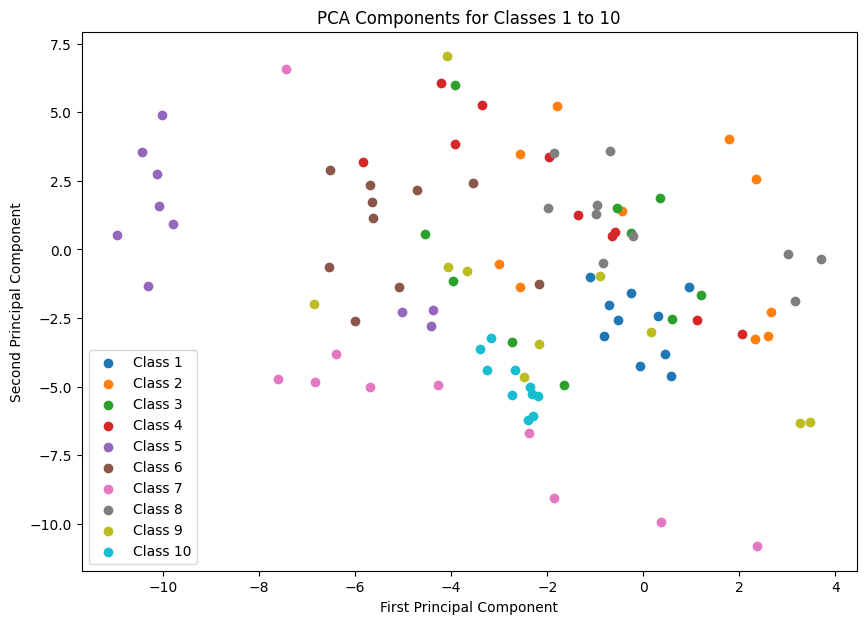

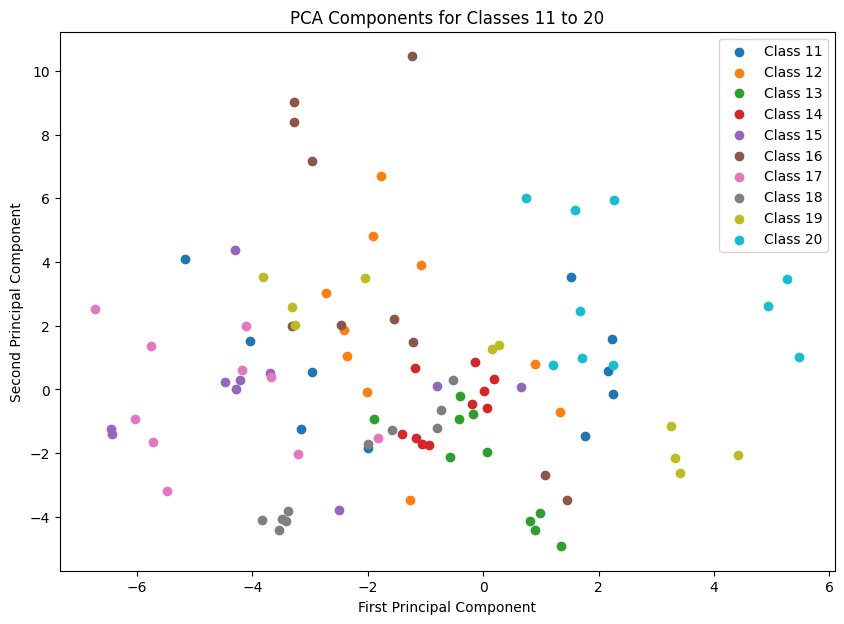

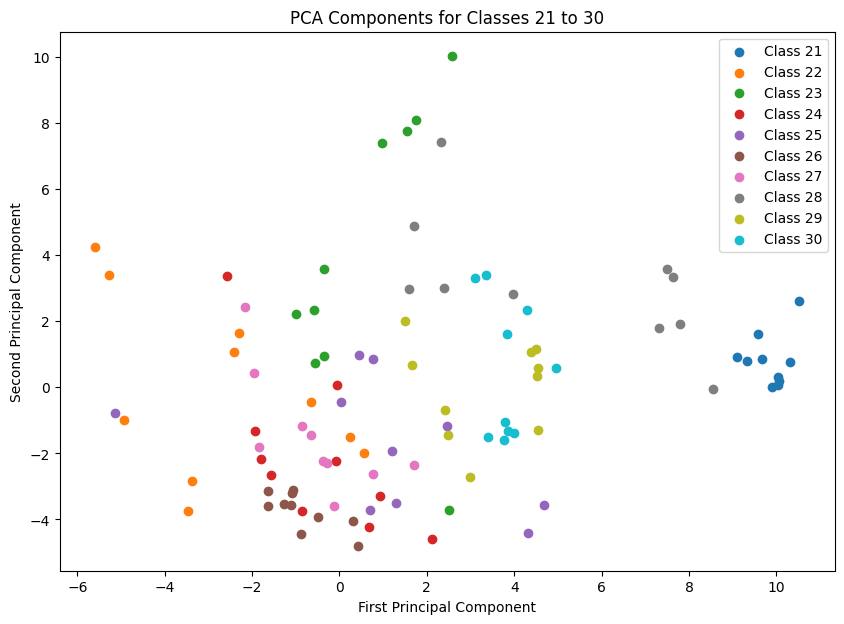

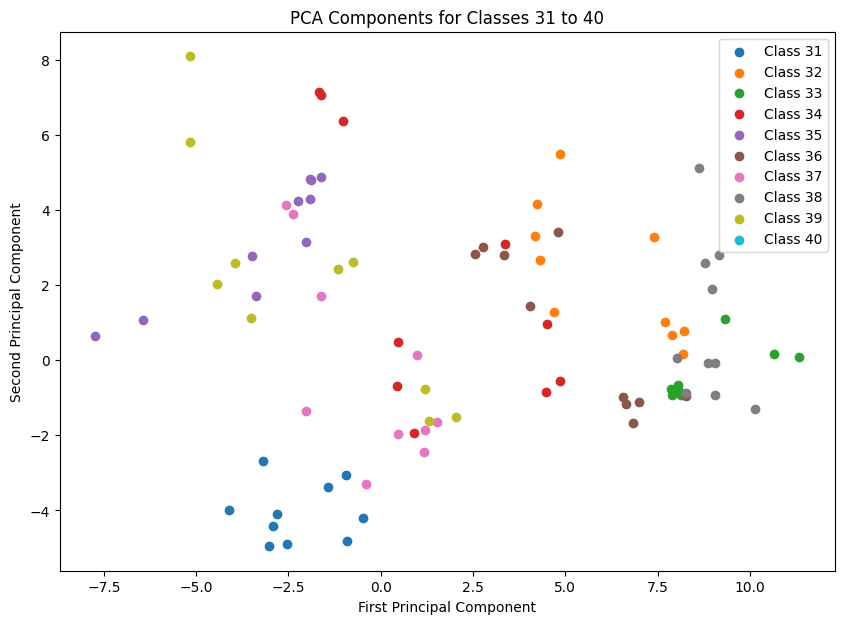

In [22]:

from sklearn.decomposition import PCA

# PCA manteniendo 2 compknentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data.drop('target', axis=1))

# Dividir las clases en 4 grupos de 10 clases cada uno
for i in range(4):
    plt.figure(figsize=(10, 7))
    for j in range(1 + i*10, 11 + i*10):
        mask = data['target'] == j
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Class {j}')
    plt.title(f'PCA Components for Classes {1 + i*10} to {10 + i*10}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()
    plt.show()


In [ ]:
'''
Resulta interesante observar que tras realizar una gran compresión, pasando de 64x64 columnas o dimensiones a 2 componentes principales,
el modelo PCA ha hecho un buen trabajo diferenciando entre las diferentes imagénes, ya que en general se encuentran bien agrupadas
'''

In [33]:
def visualizar_comparacion(data, n_components, num_images=10):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(data.drop('target', axis=1))
    X_inverse = pca.inverse_transform(X_pca)
    
    
    fig_height = 4  #Ajuste de altura
    fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, fig_height))  # Ajuste de tamaño
    
    for i in range(num_images):
        if i >= len(data):
            break
        ax = axes[0, i]
        ax.imshow(data.drop('target', axis=1).iloc[i].values.reshape(64, 64), cmap='gray')
        ax.set_title(f'Original Image {i+1}', fontsize=8)
        ax.axis('off')

        ax = axes[1, i]
        ax.imshow(X_inverse[i].reshape(64, 64), cmap='gray')
        ax.set_title(f'Recon. Image {i+1}\n{n_components} PCs', fontsize=8)
        ax.axis('off')
    
    # espaciado entre subplots
    plt.subplots_adjust(hspace=0.2, wspace=0.3)  # aquí modifico para spacio entre imagnes
    plt.show()




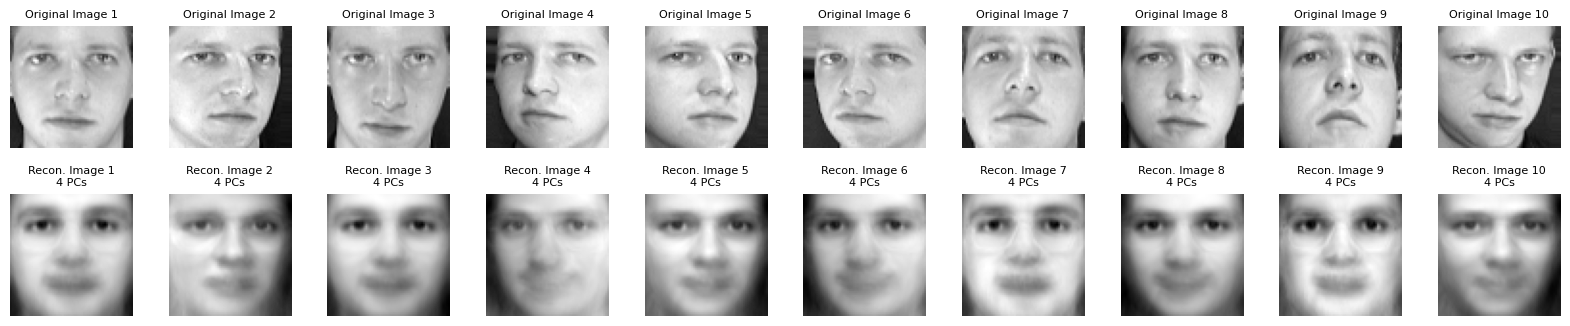

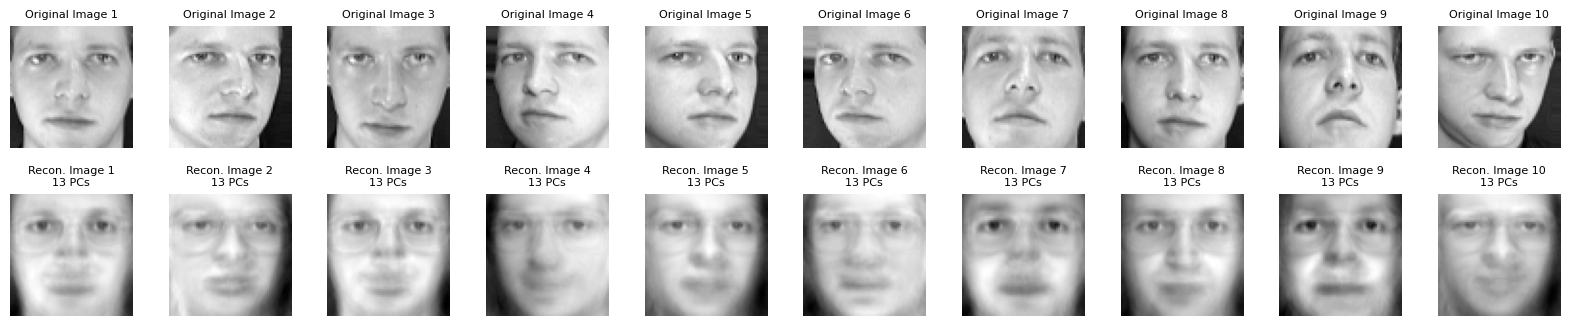

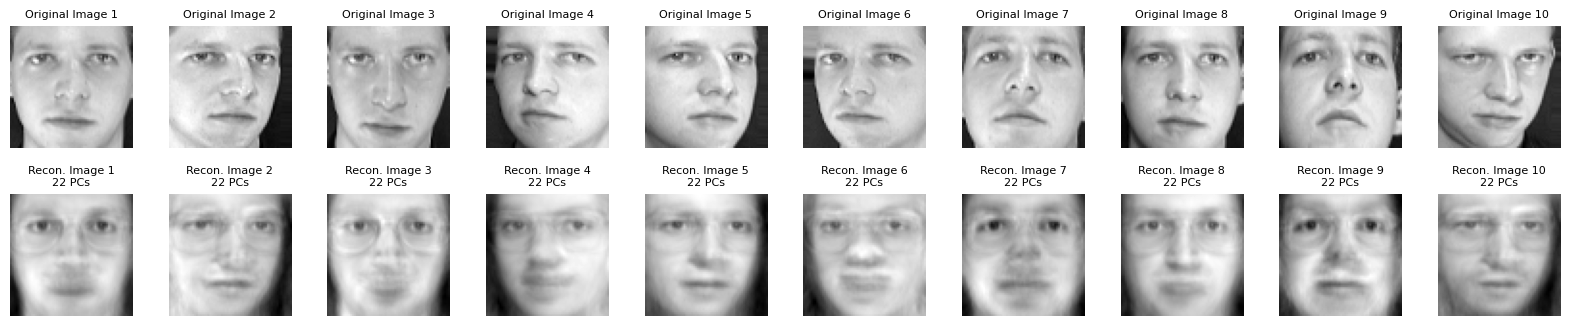

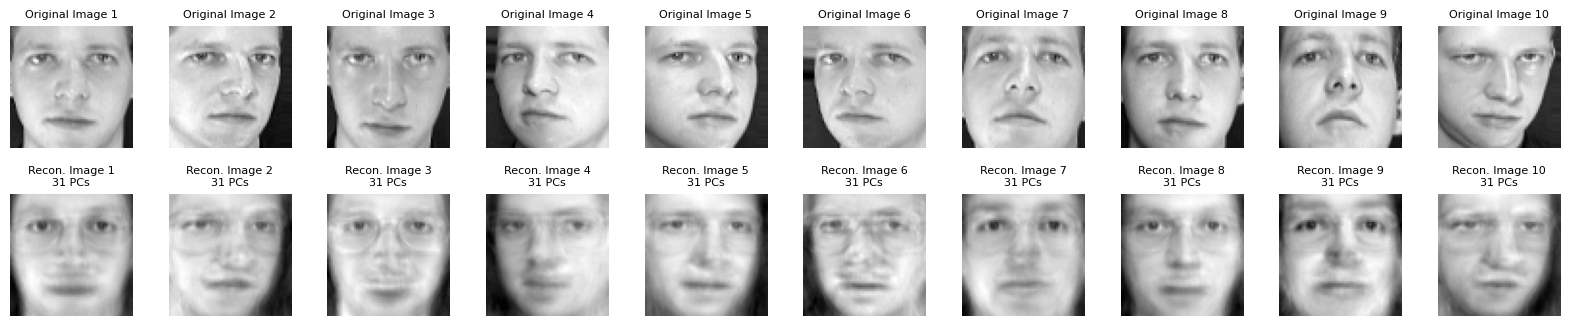

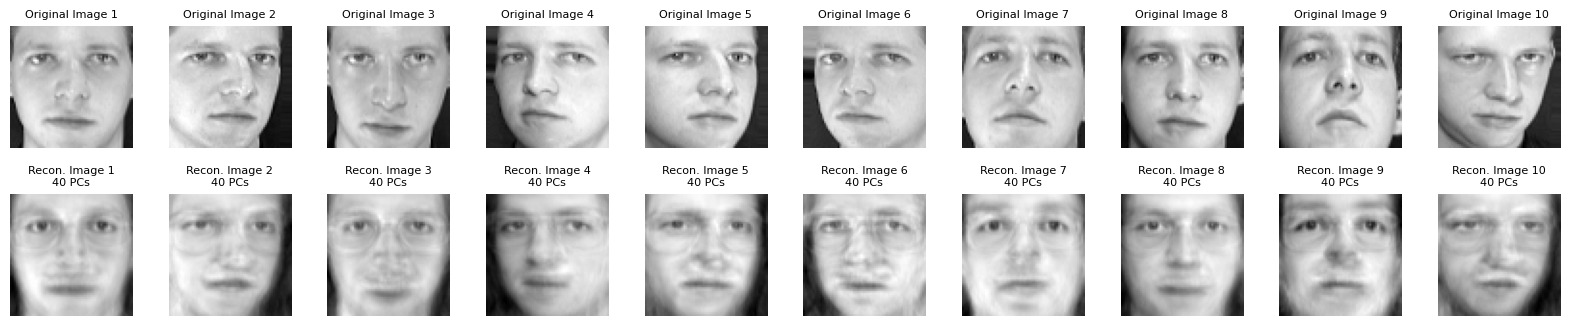

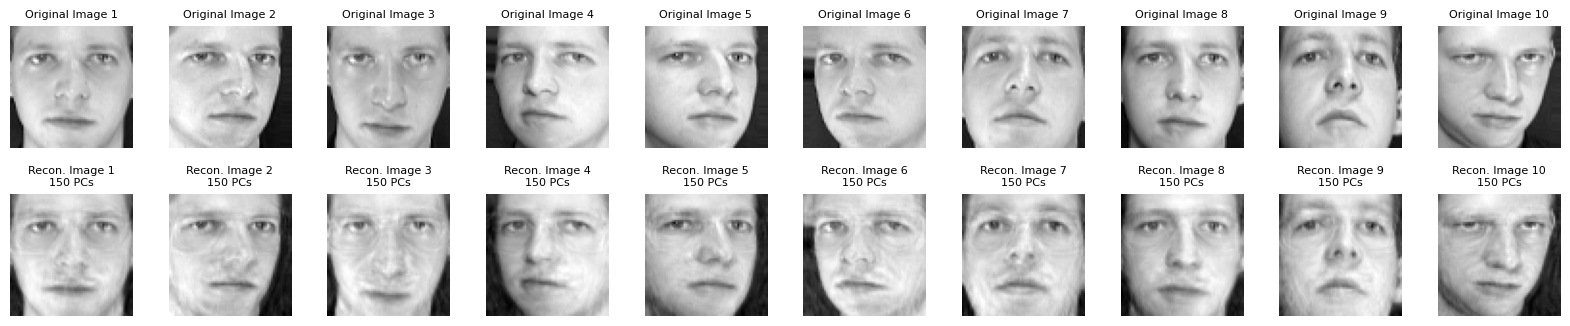

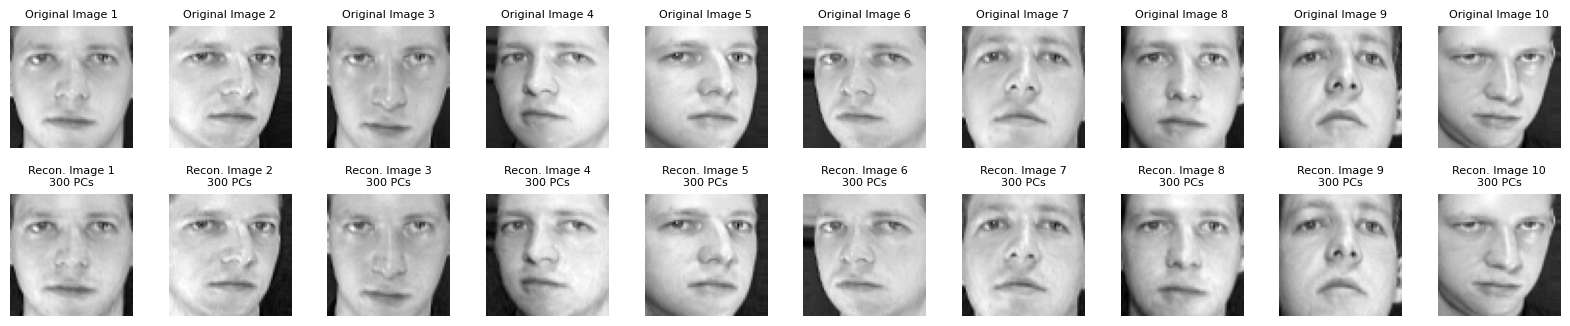

In [34]:
# bucle para iterar por los diferentes componentes en una misma llamada
for n_comp in [4, 13, 22, 31, 40, 150, 300]:
    visualizar_comparacion(data, n_comp, num_images=10)